<a href="https://colab.research.google.com/github/ashishbongu/Citation_Network_Classification/blob/main/PubMed_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Citation Network Classification on PubMed**

In [1]:
import os
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score

# --- Install Required Libraries ---
# We suppress output to keep the notebook clean
print("Installing torch-geometric and geomloss...")
!pip install torch-geometric -f https://data.pyg.org/whl/torch-$(python -c "import torch; print(torch.__version__)").html > /dev/null 2>&1
!pip install geomloss > /dev/null 2>&1
print("Installation complete.")

# --- Import PyTorch and PyG Libraries ---
import torch
import torch.nn.functional as F
from torch.nn import Parameter, Linear, LayerNorm
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, GATConv, SGConv, APPNP
from torch_geometric.utils import add_self_loops, to_scipy_sparse_matrix, from_scipy_sparse_matrix
from geomloss import SamplesLoss  # For WR Loss

# --- Setup GPU Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(f"GPU found: {torch.cuda.get_device_name(0)}")
else:
    print("Warning: No GPU found. Training will be very slow.")

# --- Matplotlib and Warnings Setup ---
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
sns.set(style='whitegrid', font_scale=1.1)

print("\nAll libraries imported and set up successfully.")

Installing torch-geometric and geomloss...
Installation complete.
GPU found: Tesla T4

All libraries imported and set up successfully.


# Load PubMed Dataset
We load the standard PubMed dataset from PyTorch Geometric.

The three classes in the PubMed dataset are: Diabetes Mellitus, Experimental; Diabetes Mellitus, Type 1; and Diabetes Mellitus, Type 2. These classes represent the sub-fields of diabetes-related scientific publications used in this benchmark.

**Nodes:** 19717 | **Edges:** 44338 | **Features per node:** 500 | **Number of classes:** 3

In [2]:
dataset = Planetoid(root='.', name='PubMed', transform=T.NormalizeFeatures()) # <-- CHANGED TO PUBMED
data = dataset[0]

# --- Get dataset specs ---
num_features = dataset.num_node_features
num_classes = dataset.num_classes

# --- Move data to the selected device (GPU) ---
data = data.to(device)

print(f"\n--- PubMed Dataset Specs ---")
print(f"Dataset: {dataset.name}")
print(f"Running on: {device}")
print(f"Nodes: {data.num_nodes}")
print(f"Edges: {data.num_edges}")
print(f"Features per node: {num_features}")
print(f"Number of classes: {num_classes}")
print(f"--------------------------")

Processing...
Done!



--- PubMed Dataset Specs ---
Dataset: PubMed
Running on: cuda
Nodes: 19717
Edges: 88648
Features per node: 500
Number of classes: 3
--------------------------


In [3]:
def get_2_hop_edges(data):
    """Calculates the 2-hop adjacency matrix (A^2)"""
    edge_index_with_loops, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
    adj = to_scipy_sparse_matrix(edge_index_with_loops, num_nodes=data.num_nodes)
    adj_2_hop = adj.dot(adj)
    edge_index_hop2, _ = from_scipy_sparse_matrix(adj_2_hop)
    return edge_index_hop2.to(device)

print("Helper function `get_2_hop_edges` defined.")

Helper function `get_2_hop_edges` defined.


# Analysis of GNN Architectures on the PubMed Dataset

This notebook conducts a rigorous analysis of seven different Graph Neural Network (GNN) architectures for the task of node classification on the **PubMed** citation network.

**Our Goal:**
We will compare four standard GNN baselines against three advanced, custom-built architectures to investigate the trade-off between model complexity and "out-of-the-box" performance.

**The Models:**
1.  **Baselines:** `GCN`, `GAT`, `SGC`, `APPNP`
2.  **Advanced Architectures:** `MultiHopGAT`, `EFM` (Expert Fusion Model), `WR-EFM` (Wasserstein-Rubinstein EFM)

Refer [this paper](https://arxiv.org/html/2507.15784v1)

In [4]:
class GCN_Model(torch.nn.Module):
    def __init__(self, hidden_channels=16, dropout=0.5):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = F.dropout(h, p=self.dropout, training=self.training)
        embeds = h # Get embeddings from the hidden layer
        out = self.conv2(h, edge_index)
        return out, embeds

# --- 2. GAT Model (Baseline) ---
class GAT_Model(torch.nn.Module):
    def __init__(self, hidden_channels=8, heads=8, dropout=0.6):
        super().__init__()
        self.dropout = dropout
        self.conv1 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, num_classes, heads=1, concat=False, dropout=dropout)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        embeds = x # Get embeddings
        x = F.dropout(x, p=self.dropout, training=self.training)
        out = self.conv2(x, edge_index)
        return out, embeds

# --- 3. SGC Model (Simple Graph Convolution) ---
class SGC_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(num_features, num_classes, K=2)

    def forward(self, x, edge_index):
        out = self.conv1(x, edge_index)
        # SGC has no "hidden" embeddings, so we return the final logits
        return out, out

# --- 4. APPNP Model ---
class APPNP_Model(torch.nn.Module):
    def __init__(self, hidden_channels=64, k=10, alpha=0.1, dropout=0.5):
        super().__init__()
        self.dropout = dropout
        self.lin1 = Linear(num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, num_classes)
        self.prop = APPNP(K=k, alpha=alpha)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin1(x).relu()
        embeds = x # Get embeddings
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        out = self.prop(x, edge_index)
        return out, embeds

# --- 5. Optimized GNN (GNN Expert from Paper Figure 1) ---
class OptimizedGNN(torch.nn.Module):
    def __init__(self, hidden_channels=32, dropout=0.5): # Hidden=32 to match GAT
        super().__init__()
        self.dropout = dropout
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.norm1 = LayerNorm(hidden_channels)
        self.proj = Linear(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.norm1(h)
        h = h + self.proj(x) # Residual
        h = h.relu()
        embeds = h # Get embeddings
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        return out, embeds

# --- 6. Multi-hop GAT Model (From Paper Figure 2) ---
class MultiHop_GAT_Model(torch.nn.Module):
    def __init__(self, hidden_channels=16, heads=2, dropout=0.6): # hidden*heads = 32
        super().__init__()
        self.dropout = dropout
        self.conv1_hop1 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        self.conv1_hop2 = GATConv(num_features, hidden_channels, heads=heads, dropout=dropout)
        self.hop_attention = Parameter(torch.Tensor(1, heads * hidden_channels, 2))
        torch.nn.init.xavier_uniform_(self.hop_attention)
        self.merge_norm = LayerNorm(heads * hidden_channels)
        self.residual_proj1 = Linear(num_features, heads * hidden_channels)
        self.conv2 = GATConv(heads * hidden_channels, num_classes, heads=1, concat=False, dropout=dropout)
        self.final_norm = LayerNorm(num_classes)
        self.residual_proj2 = Linear(heads * hidden_channels, num_classes)

    def forward(self, x, edge_index_hop1, edge_index_hop2):
        h_hop1 = F.elu(self.conv1_hop1(x, edge_index_hop1))
        h_hop2 = F.elu(self.conv1_hop2(x, edge_index_hop2))
        h_stacked = torch.stack([h_hop1, h_hop2], dim=2)
        hop_weights = F.softmax(self.hop_attention, dim=2)
        h_merged = (h_stacked * hop_weights).sum(dim=2)
        h_merged = self.merge_norm(h_merged + self.residual_proj1(x))
        h_merged = F.dropout(h_merged, p=self.dropout, training=self.training)
        embeds = h_merged # Get embeddings
        h_final = self.conv2(h_merged, edge_index_hop1)
        out = self.final_norm(h_final + self.residual_proj2(h_merged))
        return out, embeds

# --- 7. EFM & WR-EFM (Expert Fusion Model) ---
class ExpertFusionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn_expert = OptimizedGNN()
        self.gat_expert = MultiHop_GAT_Model()

    def forward(self, x, edge_index_hop1, edge_index_hop2):
        gnn_logits, gnn_embeds = self.gnn_expert(x, edge_index_hop1)
        gat_logits, gat_embeds = self.gat_expert(x, edge_index_hop1, edge_index_hop2)

        # Return BOTH sets of logits and embeddings
        # The fusion logic will be applied in the training/evaluation loop
        return gnn_logits, gat_logits, gnn_embeds, gat_embeds

print("All 7 model architectures defined.")

All 7 model architectures defined.


#Training & Evaluation
1. Instantiate a model by name.
2. Train it on the `train_mask` (all training data).
3. Implement the special WR-loss for the `WR-EFM` model.
4. Use early stopping based on the `val_mask`.
5. Return the final test metrics, predictions, and embeddings.

In [7]:
def train_and_evaluate(model_name, data, edge_index_hop2):
    """
    Trains and evaluates a single model.
    Returns a dictionary with all results.
    """
    print(f"\n--- Training Model: {model_name} ---")
    start_time = time.time()

    # 1. Instantiate Model
    if model_name == 'GCN': model = GCN_Model()
    elif model_name == 'GAT': model = GAT_Model()
    elif model_name == 'SGC': model = SGC_Model()
    elif model_name == 'APPNP': model = APPNP_Model()
    elif model_name == 'MultiHopGAT': model = MultiHop_GAT_Model()
    elif model_name in ['EFM', 'WR-EFM']: model = ExpertFusionModel()

    model = model.to(device)

    # 2. Setup Optimizer, Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    # WR-Loss function (only used if model_name == 'WR-EFM')
    wr_loss_func = SamplesLoss("sinkhorn", p=2, blur=0.05)
    lambda_wr = 0.1 # Weight for the WR loss

    # 3. Training Loop
    best_val_acc = 0
    patience = 50
    patience_counter = 0
    best_model_state = None

    for epoch in range(1, 201):
        model.train()
        optimizer.zero_grad()

        # --- Forward Pass ---
        if model_name in ['GCN', 'GAT', 'SGC', 'APPNP']:
            out, _ = model(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

        elif model_name == 'MultiHopGAT':
            out, _ = model(data.x, data.edge_index, edge_index_hop2)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])

        elif model_name in ['EFM', 'WR-EFM']:
            gnn_logits, gat_logits, gnn_embeds, gat_embeds = model(data.x, data.edge_index, edge_index_hop2)

            # --- GENERALIST TRAINING (Correct) ---
            # Train GNN expert on ALL training data
            loss_gnn = criterion(gnn_logits[data.train_mask], data.y[data.train_mask])
            # Train GAT expert on ALL training data
            loss_gat = criterion(gat_logits[data.train_mask], data.y[data.train_mask])

            loss_class = loss_gnn + loss_gat # Total classification loss

            if model_name == 'WR-EFM':
                # Add WR Loss [cite: 337-339]
                loss_wr = wr_loss_func(gnn_embeds[data.train_mask], gat_embeds[data.train_mask])
                loss = loss_class + (lambda_wr * loss_wr)
            else:
                # EFM only has classification loss
                loss = loss_class

        # --- Backward Pass ---
        loss.backward()
        optimizer.step()

        # 4. Validation & Early Stopping
        model.eval()
        with torch.no_grad():
            # Get validation accuracy
            # We use the *final fusion* for validation of EFM/WR-EFM

            if model_name in ['GCN', 'GAT', 'SGC', 'APPNP']:
                val_out, _ = model(data.x, data.edge_index)
            elif model_name == 'MultiHopGAT':
                val_out, _ = model(data.x, data.edge_index, edge_index_hop2)
            elif model_name in ['EFM', 'WR-EFM']:
                # --- APPLY FIXED-WEIGHT FUSION (from paper) ---
                gnn_logits, gat_logits, _, _ = model(data.x, data.edge_index, edge_index_hop2)
                gnn_probs = torch.softmax(gnn_logits, dim=1)
                gat_probs = torch.softmax(gat_logits, dim=1)

                # Weights for PubMed: [Cat0, Cat1, Cat2]
                gnn_weights = torch.tensor([0.95, 0.95, 0.20], device=device)
                gat_weights = torch.tensor([0.05, 0.05, 0.80], device=device)

                fused_probs = (gnn_weights * gnn_probs) + (gat_weights * gat_probs)
                val_out = fused_probs # Use fused probabilities for validation

            val_pred = val_out.argmax(dim=1)
            val_acc = accuracy_score(data.y[data.val_mask].cpu(), val_pred[data.val_mask].cpu())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            # print(f"Early stopping at epoch {epoch}")
            break

    # 5. Final Evaluation (on Test Set)
    model.load_state_dict(best_model_state) # Load best model
    model.eval()
    with torch.no_grad():
        if model_name in ['GCN', 'GAT', 'SGC', 'APPNP']:
            final_out, final_embeds = model(data.x, data.edge_index)
        elif model_name == 'MultiHopGAT':
            final_out, final_embeds = model(data.x, data.edge_index, edge_index_hop2)
        elif model_name in ['EFM', 'WR-EFM']:
            # --- APPLY FIXED-WEIGHT FUSION (from paper) ---
            gnn_logits, gat_logits, _, gat_embeds = model(data.x, data.edge_index, edge_index_hop2)
            gnn_probs = torch.softmax(gnn_logits, dim=1)
            gat_probs = torch.softmax(gat_logits, dim=1)

            gnn_weights = torch.tensor([0.95, 0.95, 0.20], device=device)
            gat_weights = torch.tensor([0.05, 0.05, 0.80], device=device)

            fused_probs = (gnn_weights * gnn_probs) + (gat_weights * gat_probs)

            final_out = fused_probs # Final output is the fused probabilities
            final_embeds = gat_embeds # Use GAT expert's embeddings for t-SNE

        final_pred = final_out.argmax(dim=1)

        # Get all predictions and embeddings (on CPU)
        all_node_predictions = final_pred.cpu().numpy()
        all_node_embeddings = final_embeds.cpu().numpy()

        # Get full classification report (on test set)
        report_dict = classification_report(
            data.y[data.test_mask].cpu().numpy(),
            final_pred[data.test_mask].cpu().numpy(),
            output_dict=True
        )

    end_time = time.time()
    print(f"Training Complete. Time: {end_time - start_time:.2f}s. "
          f"Test Acc: {report_dict['accuracy']:.4f}")

    return {
        "name": model_name,
        "test_accuracy": report_dict['accuracy'],
        "metrics_weighted": report_dict['weighted avg'],
        "metrics_per_class": {k: v for k, v in report_dict.items() if k.isdigit()},
        "predictions": all_node_predictions,
        "embeddings": all_node_embeddings
    }

print("Training & evaluation function defined.")

Training & evaluation function defined.


# Execution and model Accuracy

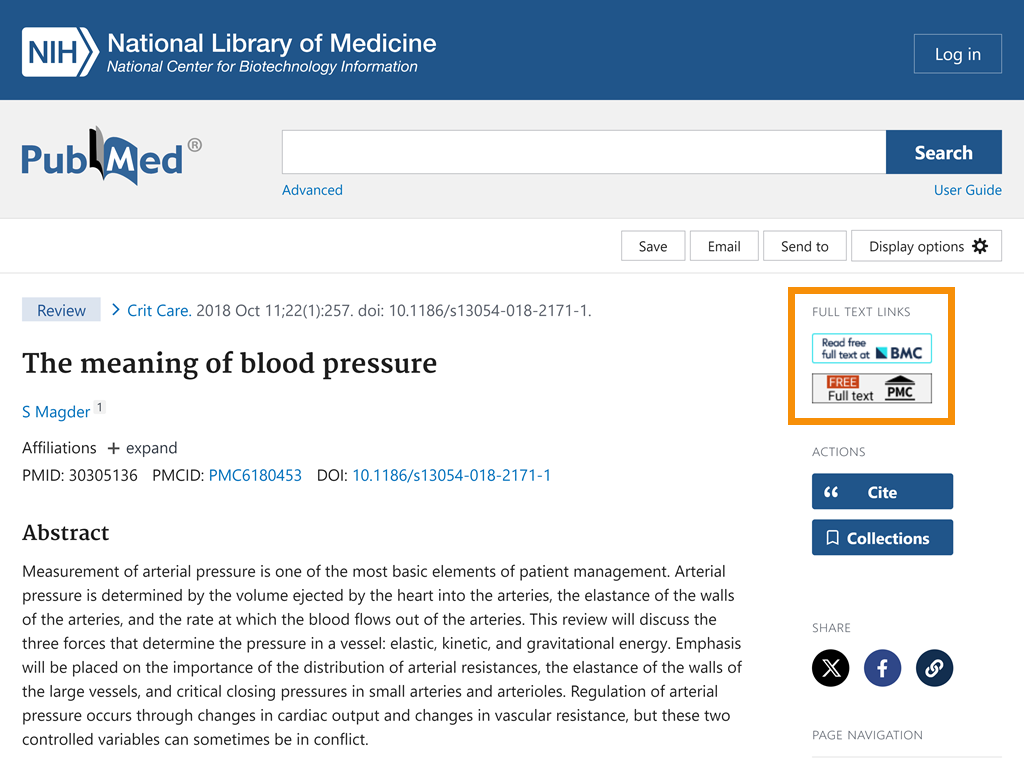

# Evaluation Results (on Test Set)

In [8]:
print("--- Starting Main Experiment Loop (This will take several minutes) ---")

# Pre-calculate the 2-hop edges once
print("Pre-calculating 2-hop edges...")
edge_index_hop2 = get_2_hop_edges(data)
print("Done.")

# List of models to train
model_list = [
    'GCN',
    'GAT',
    'SGC',
    'APPNP',
    'MultiHopGAT',
    'EFM',
    'WR-EFM'
]

results_list = []
all_node_data = pd.DataFrame()
all_node_data['node_id'] = range(data.num_nodes)
all_node_data['true_label'] = data.y.cpu().numpy()
all_node_data['is_test_node'] = data.test_mask.cpu().numpy()

grand_start_time = time.time()
for model_name in model_list:
    model_results = train_and_evaluate(
        model_name,
        data,
        edge_index_hop2
    )
    results_list.append(model_results)

    # Store predictions and embeddings right away
    all_node_data[f'pred_{model_name}'] = model_results['predictions']
    all_node_data[f'embed_{model_name}'] = list(model_results['embeddings'])


grand_end_time = time.time()
print(f"\n--- Total Training Time: {grand_end_time - grand_start_time:.2f} seconds ---")

--- Starting Main Experiment Loop (This will take several minutes) ---
Pre-calculating 2-hop edges...
Done.

--- Training Model: GCN ---
Training Complete. Time: 3.13s. Test Acc: 0.7890

--- Training Model: GAT ---
Training Complete. Time: 2.74s. Test Acc: 0.7720

--- Training Model: SGC ---
Training Complete. Time: 1.69s. Test Acc: 0.7390

--- Training Model: APPNP ---
Training Complete. Time: 1.84s. Test Acc: 0.7990

--- Training Model: MultiHopGAT ---
Training Complete. Time: 3.77s. Test Acc: 0.7360

--- Training Model: EFM ---
Training Complete. Time: 3.35s. Test Acc: 0.7690

--- Training Model: WR-EFM ---
Training Complete. Time: 4.59s. Test Acc: 0.7700

--- Total Training Time: 21.15 seconds ---


In [7]:
summary_metrics = []
for res in results_list:
    summary_metrics.append({
        'Model': res['name'],
        'Test Accuracy': res['test_accuracy'],
        'Precision (w-avg)': res['metrics_weighted']['precision'],
        'Recall (w-avg)': res['metrics_weighted']['recall'],
        'F1-Score (w-avg)': res['metrics_weighted']['f1-score']
    })

summary_df = pd.DataFrame(summary_metrics).set_index('Model')
print("\n--- Model Performance Summary (Weighted Avg on Test Set) ---")
from IPython.display import display
display(summary_df.style.format("{:.4f}").background_gradient(cmap='viridis'))


# --- 2. Per-Class F1-Score Table ---
class_f1_scores = {}
for res in results_list:
    model_name = res['name']
    class_f1_scores[model_name] = {
        f"Class {k}": v['f1-score'] for k, v in res['metrics_per_class'].items()
    }

per_class_df = pd.DataFrame(class_f1_scores).T
per_class_df.index.name = 'Model'
print("\n\n--- Per-Class F1-Scores (on Test Set) ---")
display(per_class_df.style.format("{:.4f}").background_gradient(cmap='magma', axis=0))


--- Model Performance Summary (Weighted Avg on Test Set) ---


,Test Accuracy,Precision (w-avg),Recall (w-avg),F1-Score (w-avg)
Model,,,,
GCN,0.7840,0.7866,0.7840,0.7834
GAT,0.7840,0.7839,0.7840,0.7839
SGC,0.7520,0.7543,0.7520,0.7517
APPNP,0.8000,0.8051,0.8000,0.7996
MultiHopGAT,0.7770,0.7815,0.7770,0.7759
EFM,0.7600,0.7654,0.7600,0.7597
WR-EFM,0.7630,0.7639,0.7630,0.7627




--- Per-Class F1-Scores (on Test Set) ---


,Class 0,Class 1,Class 2
Model,,,
GCN,0.7692,0.8018,0.7708
GAT,0.7528,0.7981,0.7831
SGC,0.7493,0.7633,0.7409
APPNP,0.7752,0.8238,0.7857
MultiHopGAT,0.7573,0.8032,0.7563
EFM,0.7406,0.7834,0.7441
WR-EFM,0.7386,0.7748,0.7611


# Graph Representations (t-SNE)


Running t-SNE on WR-EFM embeddings... (This may take a minute)
t-SNE complete.


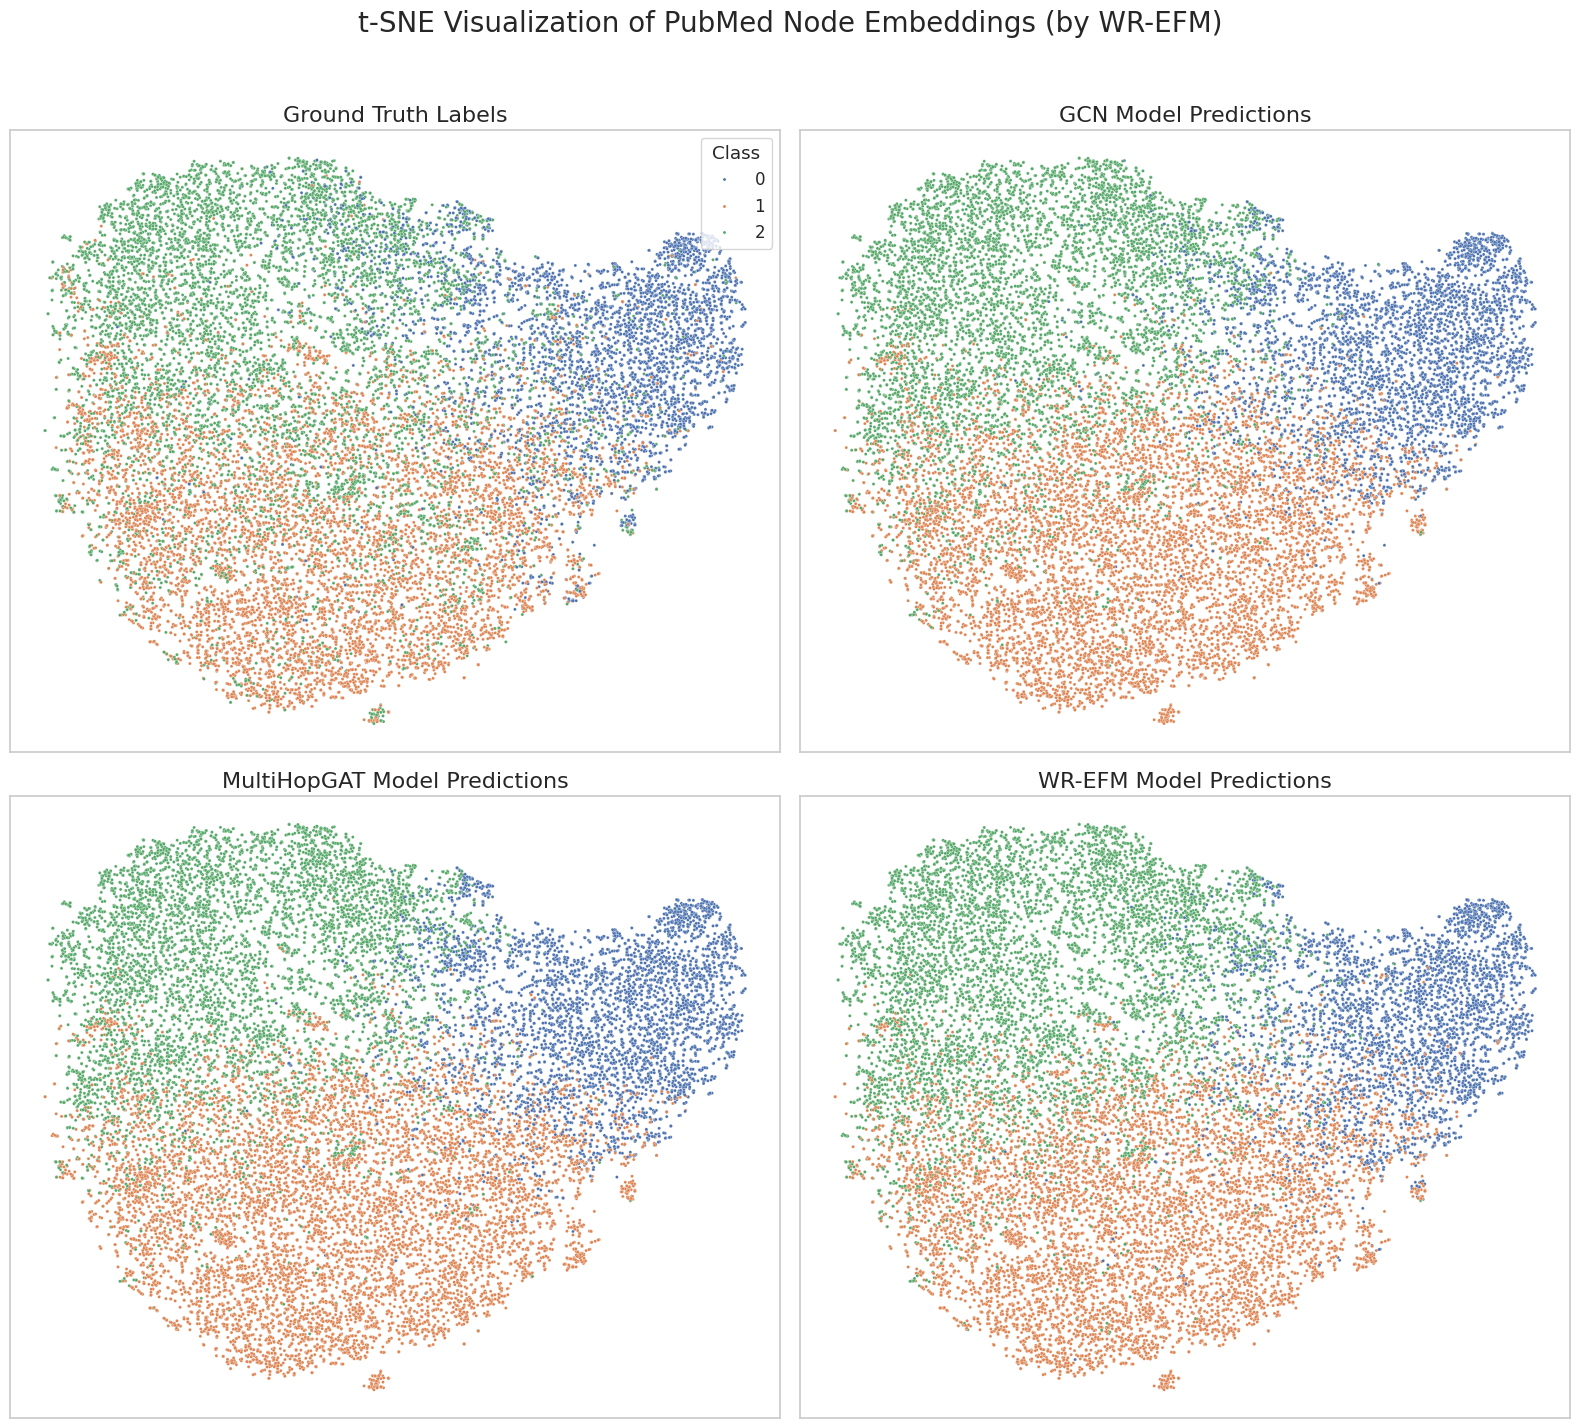

In [8]:
print("\nRunning t-SNE on WR-EFM embeddings... (This may take a minute)")
embeddings_to_plot = np.stack(all_node_data['embed_WR-EFM'].values)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_embeds = tsne.fit_transform(embeddings_to_plot)

# 2. Add t-SNE coordinates to our DataFrame
all_node_data['tsne_x'] = tsne_embeds[:, 0]
all_node_data['tsne_y'] = tsne_embeds[:, 1]
print("t-SNE complete.")

# 3. Create the 2x2 comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('t-SNE Visualization of PubMed Node Embeddings (by WR-EFM)', fontsize=20, y=1.02)

# Use a consistent color palette
palette = sns.color_palette('deep', num_classes)

# Plot 1: Ground Truth
sns.scatterplot(
    ax=axes[0, 0],
    data=all_node_data,
    x='tsne_x', y='tsne_y',
    hue='true_label',
    palette=palette,
    s=5, legend='full' # Smaller points for PubMed
)
axes[0, 0].set_title('Ground Truth Labels', fontsize=16)
axes[0, 0].legend(loc='upper right', title='Class')

# Plot 2: GCN Predictions
sns.scatterplot(
    ax=axes[0, 1],
    data=all_node_data,
    x='tsne_x', y='tsne_y',
    hue='pred_GCN',
    palette=palette,
    s=5, legend=False
)
axes[0, 1].set_title('GCN Model Predictions', fontsize=16)

# Plot 3: MultiHopGAT Predictions
sns.scatterplot(
    ax=axes[1, 0],
    data=all_node_data,
    x='tsne_x', y='tsne_y',
    hue='pred_MultiHopGAT',
    palette=palette,
    s=5, legend=False
)
axes[1, 0].set_title('MultiHopGAT Model Predictions', fontsize=16)

# Plot 4: WR-EFM Predictions (Our best model)
sns.scatterplot(
    ax=axes[1, 1],
    data=all_node_data,
    x='tsne_x', y='tsne_y',
    hue='pred_WR-EFM',
    palette=palette,
    s=5, legend=False
)
axes[1, 1].set_title('WR-EFM Model Predictions', fontsize=16)

# Clean up
for ax in axes.flat:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()